In [1]:
import pandas as pd
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('eventlog_large.csv', sep=';')
df.head()

,Case_ID,Activity,User,Timestamp
0,1,a,u2,2016-04-15 08:41:28
1,1,b,u3,2016-04-18 12:55:01
2,2,a,u2,2016-04-18 20:40:14
3,1,d,u5,2016-04-19 07:22:59
4,2,b,u4,2016-04-21 22:42:39


In [3]:
#Nodes dataframe for process flow
df_node = df.copy()
df_node = df_node[['Case_ID','Activity','Timestamp','User']]
df_node = df_node.sort_values(by=['Case_ID','Timestamp','Activity'],ascending=True).reset_index(drop=True)

df_node

,Case_ID,Activity,Timestamp,User
0,1,a,2016-04-15 08:41:28,u2
1,1,b,2016-04-18 12:55:01,u3
2,1,d,2016-04-19 07:22:59,u5
3,1,e,2016-04-23 15:06:58,u7
4,1,f,2016-04-24 19:18:32,u7
...,...,...,...,...
45374,7549,d,2120-07-15 03:40:37,u5
45375,7549,g,2120-07-19 05:39:32,u6
45376,7549,e,2120-07-20 18:29:17,u7
45377,7549,f,2120-07-22 03:43:02,u7


In [4]:
sortnew1 = df_node.iloc[:-1,:]
sortnew2 = df_node.iloc[1:,:].reset_index(drop=True)
sortnew = pd.concat([sortnew1,sortnew2],axis=1)
sortnew.columns = ['Case_ID','Start Activity','Start Time','Start User','Case_ID2','End Activity','End Time','End user']
sortnew['Comparison'] = sortnew.apply(lambda x: True if x['Case_ID'] == x['Case_ID2'] else False,axis=1)
sortnew = sortnew[sortnew['Comparison'] == True]

sortnew1 = sortnew[['Case_ID', 'Start User','End user']]
countsort = sortnew1.groupby(['Start User','End user']).size()
newcountsort = countsort.to_frame(name='Weight').reset_index()
newcountsort

,Start User,End user,Weight
0,u1,u3,2113
1,u1,u4,890
2,u2,u3,3168
3,u2,u4,1378
4,u3,u1,642
5,u3,u2,662
6,u3,u5,3155
7,u3,u6,822
8,u4,u1,285
9,u4,u2,277


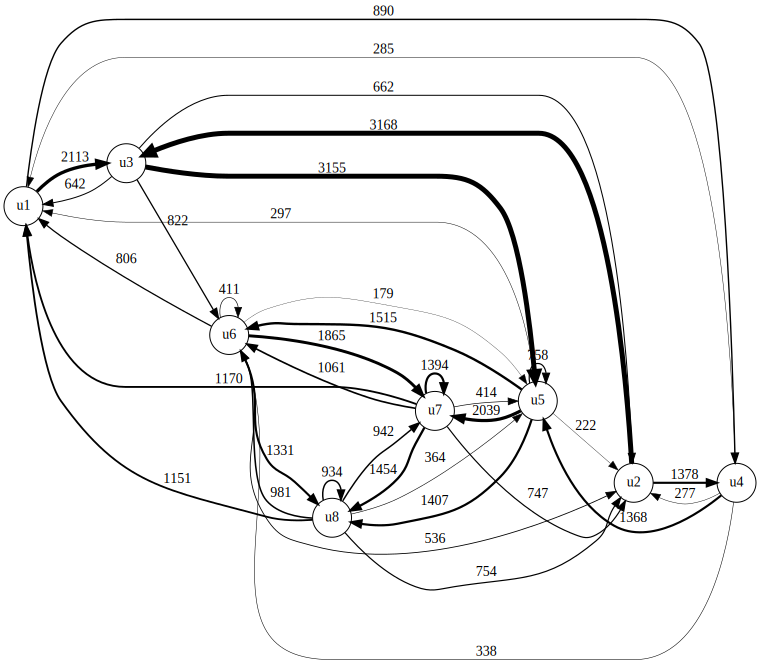

In [5]:
# Activity flow towards the users
G = graphviz.Digraph(format='jpeg')

G.attr(rankdir='LR')
G.attr('node', shape='circle')

max_node = 5
max_case_id = newcountsort['Weight'].max()

nodelist = []
for idx, row in newcountsort.iterrows():
    node1, node2, weight = [str(i) for i in row]
    
    if node1 not in nodelist:
        G.node(node1)
        nodelist.append(node2)
    if node2 not in nodelist:
        G.node(node2)
        nodelist.append(node2)
        
    G.edge(node1, node2, label = weight, penwidth=str(int(weight)/max_case_id*max_node))
    
G

In [6]:
# Activity flow per activity
sortnew2 = sortnew[['Case_ID', 'Start Activity','End Activity']]
countsort2 = sortnew2.groupby(['Start Activity','End Activity']).size()
newcountsort1 = countsort2.to_frame(name='Weight').reset_index()
newcountsort1

,Start Activity,End Activity,Weight
0,a,b,7549
1,b,c,1866
2,b,d,5683
3,d,e,2820
4,d,g,2863
5,e,f,4724
6,e,g,959
7,f,g,1861
8,f,h,3822
9,g,e,2863


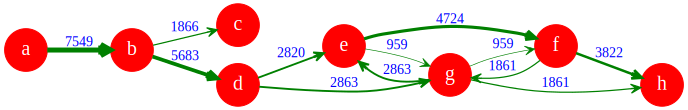

In [7]:
H = graphviz.Digraph(format='jpeg')

H.attr(rankdir='LR')
H.attr('node', shape='circle', color='red', style='filled', fontsize='20', fontcolor='white')
H.attr('edge', arrowhead='vee', arrowtail='inv', color='green', fontcolor='blue')

max_node = 5
max_case_id = newcountsort1['Weight'].max()

nodelist2 = []
for idx, row in newcountsort1.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        H.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        H.node(node22)
        nodelist2.append(node22)
        
    H.edge(node11, node22, label = weight2, penwidth=str(int(weight2)/max_case_id*max_node))
    
H

In [8]:
#Average Time per activity
sortnewtime = sortnew.copy()
sortnewtime['Start Time'] = pd.to_datetime(sortnewtime['Start Time'])
sortnewtime['End Time'] = pd.to_datetime(sortnewtime['End Time'])
sortnewtime['Duration'] = sortnewtime['End Time'] - sortnewtime['Start Time']

sortnewtime2 = sortnewtime.copy()
sortnewtime2 = sortnewtime2[['Start Activity','End Activity','Duration']]
sortnewtime2['Duration'] = sortnewtime2['Duration'].apply(lambda x: round(x.total_seconds(),0))
sortnewtime2 = sortnewtime2.groupby(['Start Activity','End Activity']).mean().reset_index()
sortnewtime2['Duration'] = round(sortnewtime2['Duration']/86400,2)
sortnewtime2

,Start Activity,End Activity,Duration
0,a,b,2.13
1,b,c,1.29
2,b,d,1.54
3,d,e,3.39
4,d,g,3.42
5,e,f,1.75
6,e,g,1.11
7,f,g,2.25
8,f,h,2.29
9,g,e,2.59


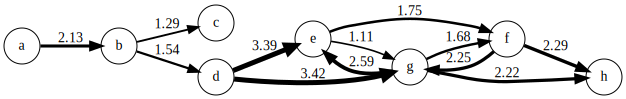

In [9]:
Z = graphviz.Digraph(format='jpeg')

Z.attr(rankdir='LR')
Z.attr('node', shape='circle')

max_node = 5
max_case_id = sortnewtime2['Duration'].max()

nodelist2 = []
for idx, row in sortnewtime2.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        Z.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        Z.node(node22)
        nodelist2.append(node22)
        
    Z.edge(node11, node22, label = weight2, penwidth=str(float(weight2)/max_case_id*max_node)) 
Z

In [10]:
# Individual activities per user
iapu = df_node.copy()
iapu = iapu[['Activity','User']]
iapu = iapu.groupby(['Activity','User']).size()
iapu = iapu.to_frame(name='Weight').reset_index()
iapu

,Activity,User,Weight
0,a,u1,3003
1,a,u2,4546
2,b,u3,5281
3,b,u4,2268
4,c,u1,927
5,c,u2,939
6,d,u5,4523
7,d,u6,1160
8,e,u7,3412
9,e,u8,2271


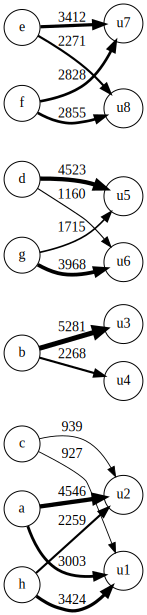

In [11]:
ZA = graphviz.Digraph(format='jpeg')

ZA.attr(rankdir='LR')
ZA.attr('node', shape='circle')

max_node = 5
max_case_id = iapu['Weight'].max()
nodelist2 = []
for idx, row in iapu.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        ZA.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        ZA.node(node22)
        nodelist2.append(node22)
        
    ZA.edge(node11, node22, label = weight2, penwidth=str(int(weight2)/max_case_id*max_node))
ZA

In [12]:
df_plot = df_node.copy()
df_plot = df_plot[df_plot['Case_ID'] <= 20]
df_plot['Timestamp'] = pd.to_datetime(df_plot['Timestamp'])
df_plot

,Case_ID,Activity,Timestamp,User
0,1,a,2016-04-15 08:41:28,u2
1,1,b,2016-04-18 12:55:01,u3
2,1,d,2016-04-19 07:22:59,u5
3,1,e,2016-04-23 15:06:58,u7
4,1,f,2016-04-24 19:18:32,u7
...,...,...,...,...
115,19,f,2016-07-25 23:14:20,u8
116,19,h,2016-07-27 18:08:34,u2
117,20,a,2016-07-21 04:22:41,u2
118,20,b,2016-07-23 04:40:45,u3


Text(0.5, 0.98, 'Analyzing events timeline for the first 20 events')

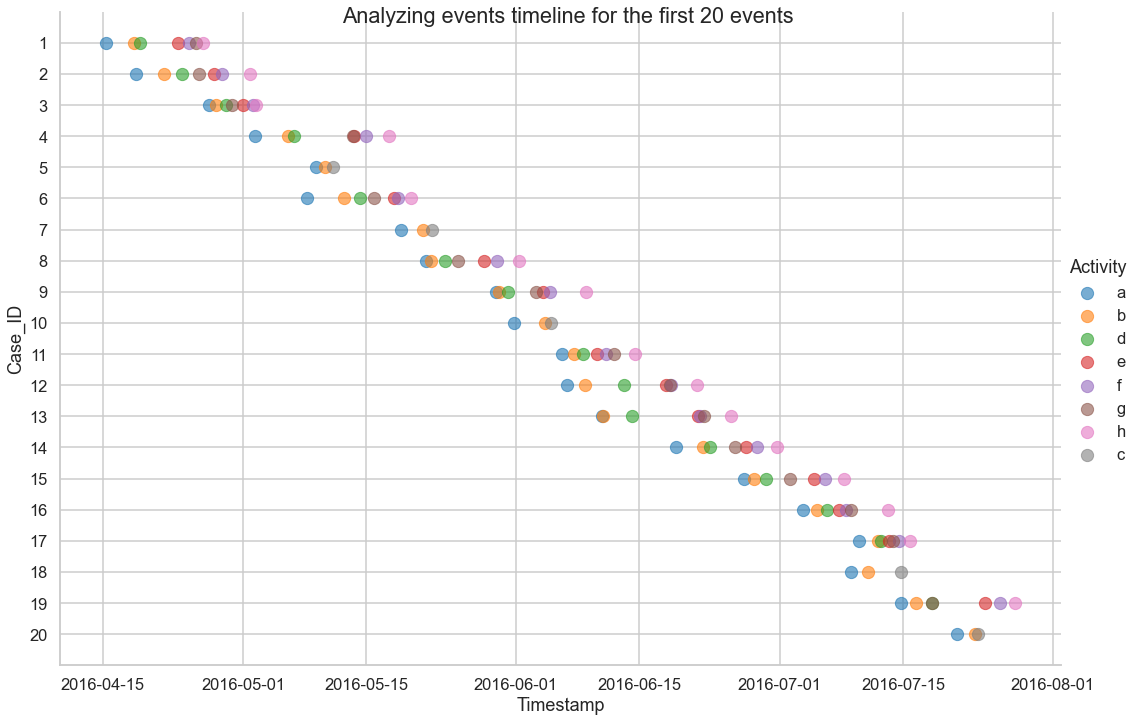

In [13]:
sns.set_style('whitegrid')
sns.set_context('talk')
activity_plot = sns.lmplot(x='Timestamp',y='Case_ID', data=df_plot, hue='Activity',height=10, aspect=1.5,fit_reg=False, scatter_kws={'s':150, 'alpha':0.6})
activity_plot.set(ylim=(max(df_plot['Case_ID'])+1,0), yticks=(df_plot['Case_ID']).unique())
activity_plot.fig.suptitle('Analyzing events timeline for the first 20 events')

In [14]:
# Variants
variants = df_node.copy()
variants['Count'] = variants.groupby('Case_ID').cumcount()+1
variants = variants.pivot(index='Case_ID', columns='Count', values='Activity')
variants_col = variants.columns
variants = variants.fillna('X')
variants = variants.astype('str')
variants['Trace'] = variants.apply(lambda x: ','.join(x),axis=1)
variants['Trace'] = variants['Trace'].apply(lambda x: x.replace(',X',''))
variants

Count,1,2,3,4,5,6,7,Trace
Case_ID,,,,,,,,
1,a,b,d,e,f,g,h,"a,b,d,e,f,g,h"
2,a,b,d,g,e,f,h,"a,b,d,g,e,f,h"
3,a,b,d,g,e,f,h,"a,b,d,g,e,f,h"
4,a,b,d,g,e,f,h,"a,b,d,g,e,f,h"
5,a,b,c,X,X,X,X,"a,b,c"
...,...,...,...,...,...,...,...,...
7545,a,b,d,e,f,g,h,"a,b,d,e,f,g,h"
7546,a,b,d,e,f,g,h,"a,b,d,e,f,g,h"
7547,a,b,d,g,e,f,h,"a,b,d,g,e,f,h"


In [15]:
variants_num = variants[['Trace',1]].groupby(['Trace'], as_index=False).count()
variants_num = variants_num.sort_values(by=1, ascending=False).reset_index()
del variants_num['index']
variants_num = variants_num.reset_index()
variants_num['index'] = variants_num['index']+1
variants_num = variants_num.rename(columns={'index':'Variants',1:'No of occurance'})
variants_num

Count,Variants,Trace,No of occurance
0,1,"a,b,d,g,e,f,h",2863
1,2,"a,b,c",1866
2,3,"a,b,d,e,f,g,h",1861
3,4,"a,b,d,e,g,f,h",959


In [16]:
variant_merge = variants.copy()
variant_merge = variant_merge.reset_index()
variant_merge = variant_merge.merge(variants_num, on='Trace') #.reset_index()
variant_merge = variant_merge.sort_values(by=('Case_ID')).reset_index(drop=True)
variant_merge = variant_merge.drop(variants_col, axis=1)
variant_merge = variant_merge.drop(['No of occurance','Trace'], axis=1)

In [17]:
df_variants = df_node.copy()
df_variants = df_variants.merge(variant_merge, on='Case_ID')
df_variants

,Case_ID,Activity,Timestamp,User,Variants
0,1,a,2016-04-15 08:41:28,u2,3
1,1,b,2016-04-18 12:55:01,u3,3
2,1,d,2016-04-19 07:22:59,u5,3
3,1,e,2016-04-23 15:06:58,u7,3
4,1,f,2016-04-24 19:18:32,u7,3
...,...,...,...,...,...
45374,7549,d,2120-07-15 03:40:37,u5,1
45375,7549,g,2120-07-19 05:39:32,u6,1
45376,7549,e,2120-07-20 18:29:17,u7,1
45377,7549,f,2120-07-22 03:43:02,u7,1


In [18]:
# Variants Comparison
df_variants_1 = df_variants[df_variants['Variants'] == 1].reset_index().drop(['index','Variants'], axis=1)
df_variants_3 = df_variants[df_variants['Variants'] == 3].reset_index().drop(['index','Variants'], axis=1)
df_variants_4 = df_variants[df_variants['Variants'] == 4].reset_index().drop(['index','Variants'], axis=1)

In [19]:
df_variants_1

,Case_ID,Activity,Timestamp,User
0,2,a,2016-04-18 20:40:14,u2
1,2,b,2016-04-21 22:42:39,u4
2,2,d,2016-04-24 01:29:27,u6
3,2,g,2016-04-25 22:36:27,u5
4,2,e,2016-04-27 16:12:28,u7
...,...,...,...,...
20036,7549,d,2120-07-15 03:40:37,u5
20037,7549,g,2120-07-19 05:39:32,u6
20038,7549,e,2120-07-20 18:29:17,u7
20039,7549,f,2120-07-22 03:43:02,u7


In [20]:
sortnew11 = df_variants_1.iloc[:-1,:]
sortnew22 = df_variants_1.iloc[1:,:].reset_index(drop=True)
sortnew1 = pd.concat([sortnew11,sortnew22],axis=1)

sortnew1.columns = ['Case_ID','Start Activity','Start Time','Start User','Case_ID2','End Activity','End Time','End User']
sortnew1['Comparison'] = sortnew1.apply(lambda x: True if x['Case_ID'] == x['Case_ID2'] else False,axis=1)
sortnew1 = sortnew1[sortnew1['Comparison'] == True]

sortnewtime1 = sortnew1.copy()
sortnewtime1['Start Time'] = pd.to_datetime(sortnewtime1['Start Time'])
sortnewtime1['End Time'] = pd.to_datetime(sortnewtime1['End Time'])
sortnewtime1['Duration'] = sortnewtime1['End Time'] - sortnewtime1['Start Time']

sortnewtime21 = sortnewtime1.copy()
sortnewtime21 = sortnewtime21[['Start User','End User','Duration']]
sortnewtime21['Duration'] = sortnewtime21['Duration'].apply(lambda x: round(x.total_seconds(),0))
sortnewtime21 = sortnewtime21.groupby(['Start User','End User']).mean().reset_index()
sortnewtime21['Duration'] = round(sortnewtime21['Duration']/86400,2)
sortnewtime21

,Start User,End User,Duration
0,u1,u3,2.14
1,u1,u4,2.07
2,u2,u3,2.15
3,u2,u4,2.04
4,u3,u5,1.43
5,u3,u6,1.92
6,u4,u5,1.31
7,u4,u6,2.01
8,u5,u5,3.32
9,u5,u6,3.53


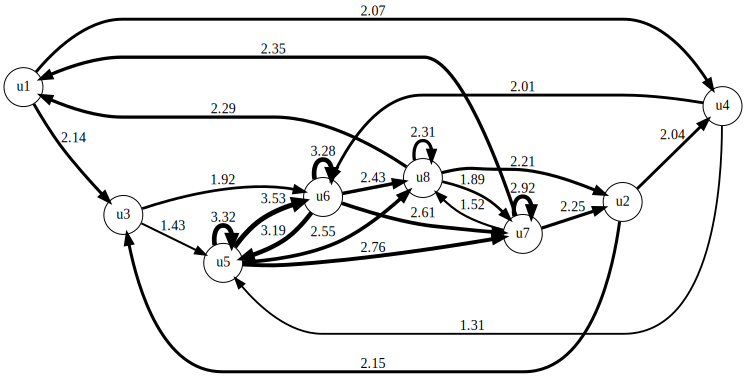

In [21]:
H1 = graphviz.Digraph(format='jpeg')

H1.attr(rankdir='LR')
H1.attr('node', shape='circle')

max_node = 5
max_case_id = sortnewtime21['Duration'].max()

nodelist2 = []
for idx, row in sortnewtime21.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        H1.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        H1.node(node22)
        nodelist2.append(node22)
        
    H1.edge(node11, node22, label = weight2, penwidth=str(float(weight2)/max_case_id*max_node))
    
H1

In [22]:
sortnew13 = df_variants_3.iloc[:-1,:]
sortnew23 = df_variants_3.iloc[1:,:].reset_index(drop=True)
sortnew3 = pd.concat([sortnew13,sortnew23],axis=1)

sortnew3.columns = ['Case_ID','Start Activity','Start Time','Start User','Case_ID2','End Activity','End Time','End User']
sortnew3['Comparison'] = sortnew3.apply(lambda x: True if x['Case_ID'] == x['Case_ID2'] else False,axis=1)
sortnew3 = sortnew3[sortnew3['Comparison'] == True]

sortnewtime3 = sortnew3.copy()
sortnewtime3['Start Time'] = pd.to_datetime(sortnewtime3['Start Time'])
sortnewtime3['End Time'] = pd.to_datetime(sortnewtime3['End Time'])
sortnewtime3['Duration'] = sortnewtime3['End Time'] - sortnewtime3['Start Time']

sortnewtime23 = sortnewtime3.copy()
sortnewtime23 = sortnewtime23[['Start User','End User','Duration']]
sortnewtime23['Duration'] = sortnewtime23['Duration'].apply(lambda x: round(x.total_seconds(),0))
sortnewtime23 = sortnewtime23.groupby(['Start User','End User']).mean().reset_index()
sortnewtime23['Duration'] = round(sortnewtime23['Duration']/86400,2)
sortnewtime23

,Start User,End User,Duration
0,u1,u3,2.14
1,u1,u4,1.98
2,u2,u3,2.13
3,u2,u4,2.03
4,u3,u5,1.38
5,u3,u6,2.21
6,u4,u5,1.25
7,u4,u6,2.29
8,u5,u1,2.11
9,u5,u2,2.26


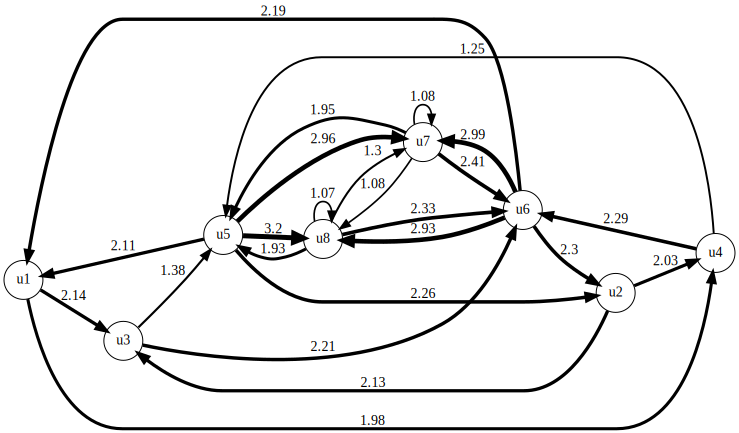

In [23]:
H3 = graphviz.Digraph(format='jpeg')

H3.attr(rankdir='LR')
H3.attr('node', shape='circle')

max_node = 5
max_case_id = sortnewtime23['Duration'].max()

nodelist2 = []
for idx, row in sortnewtime23.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        H3.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        H3.node(node22)
        nodelist2.append(node22)
        
    H3.edge(node11, node22, label = weight2, penwidth=str(float(weight2)/max_case_id*max_node))

H3

In [24]:
# Relative duration of activities

rdoa = df_node.copy()
rdoa = rdoa[['Case_ID','Activity','Timestamp']]
rdoa['Timestamp'] = pd.to_datetime(rdoa['Timestamp'])
rdoa['Cum_Duration'] = rdoa.groupby(['Case_ID'])['Timestamp'].transform(lambda x: (x-x.iloc[0]).dt.total_seconds())
rdoa['Cum_Duration'] = round(rdoa['Cum_Duration']/86400,0)
rdoa_plot = rdoa[rdoa['Case_ID'] <= 20]
# rdoa_order = rdoa.sort_values(by=['Cum_Duration'], ascending=[True]).Cum_Duration.values
# rdoa = rdoa.sort_values(by=['Cum_Duration'], ascending=[True])
rdoa_plot

,Case_ID,Activity,Timestamp,Cum_Duration
0,1,a,2016-04-15 08:41:28,0.0
1,1,b,2016-04-18 12:55:01,3.0
2,1,d,2016-04-19 07:22:59,4.0
3,1,e,2016-04-23 15:06:58,8.0
4,1,f,2016-04-24 19:18:32,9.0
...,...,...,...,...
115,19,f,2016-07-25 23:14:20,11.0
116,19,h,2016-07-27 18:08:34,13.0
117,20,a,2016-07-21 04:22:41,0.0
118,20,b,2016-07-23 04:40:45,2.0


Text(0.5, 0.98, 'Analyzing events timeline for the first 20 events')

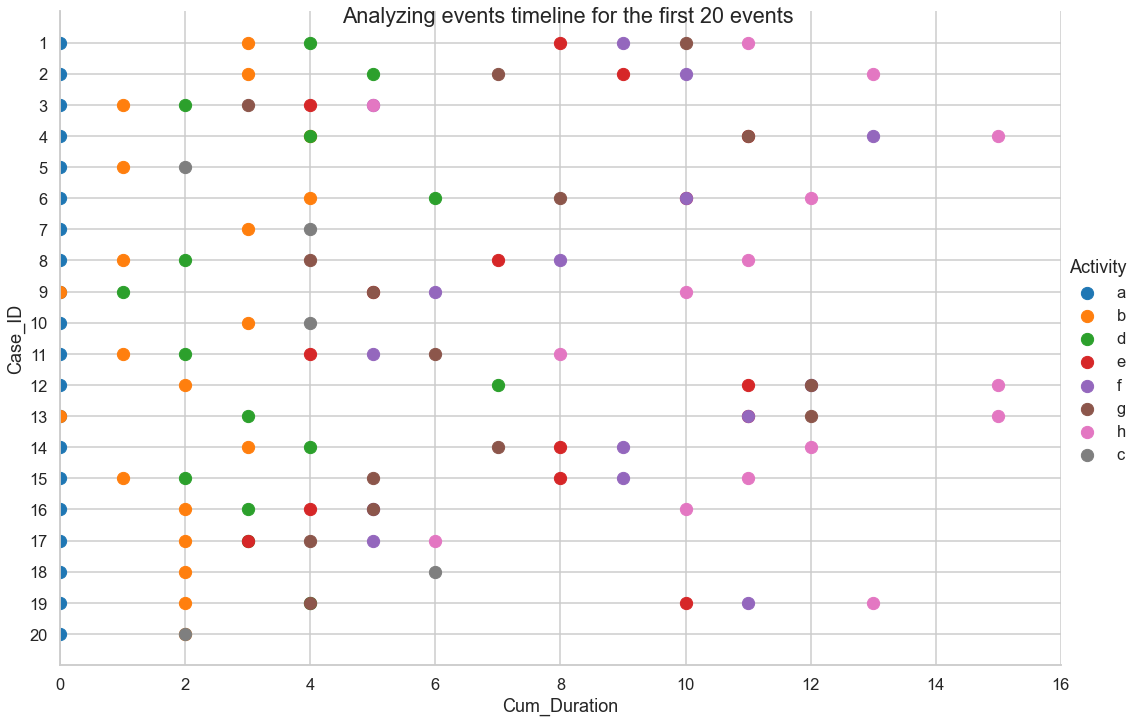

In [25]:
sns.set_style('whitegrid')
sns.set_context('talk')
relactivity_plot = sns.lmplot(x='Cum_Duration',y='Case_ID', data=rdoa_plot, hue='Activity',height=10, aspect=1.5,fit_reg=False, scatter_kws={'s':150, 'alpha':1.0})
relactivity_plot.set(ylim=(max(rdoa_plot['Case_ID'])+1,0), yticks=(rdoa_plot['Case_ID']).unique(), xlim=(0, max(rdoa_plot['Cum_Duration'])+1))
relactivity_plot.fig.suptitle('Analyzing events timeline for the first 20 events')

In [26]:
#TODO: Case duration for each case id